# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

### **_WARNING_**
The BERT transformer is used in this project. If nvidia driver is not installed in your local machine, I recommend using Google Colab and use their remote GPU for faster runtime.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [7]:
df_reviews.duplicated().sum()

0

In [8]:
df_reviews.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489


## EDA

Let's check the number of movies and reviews over years.

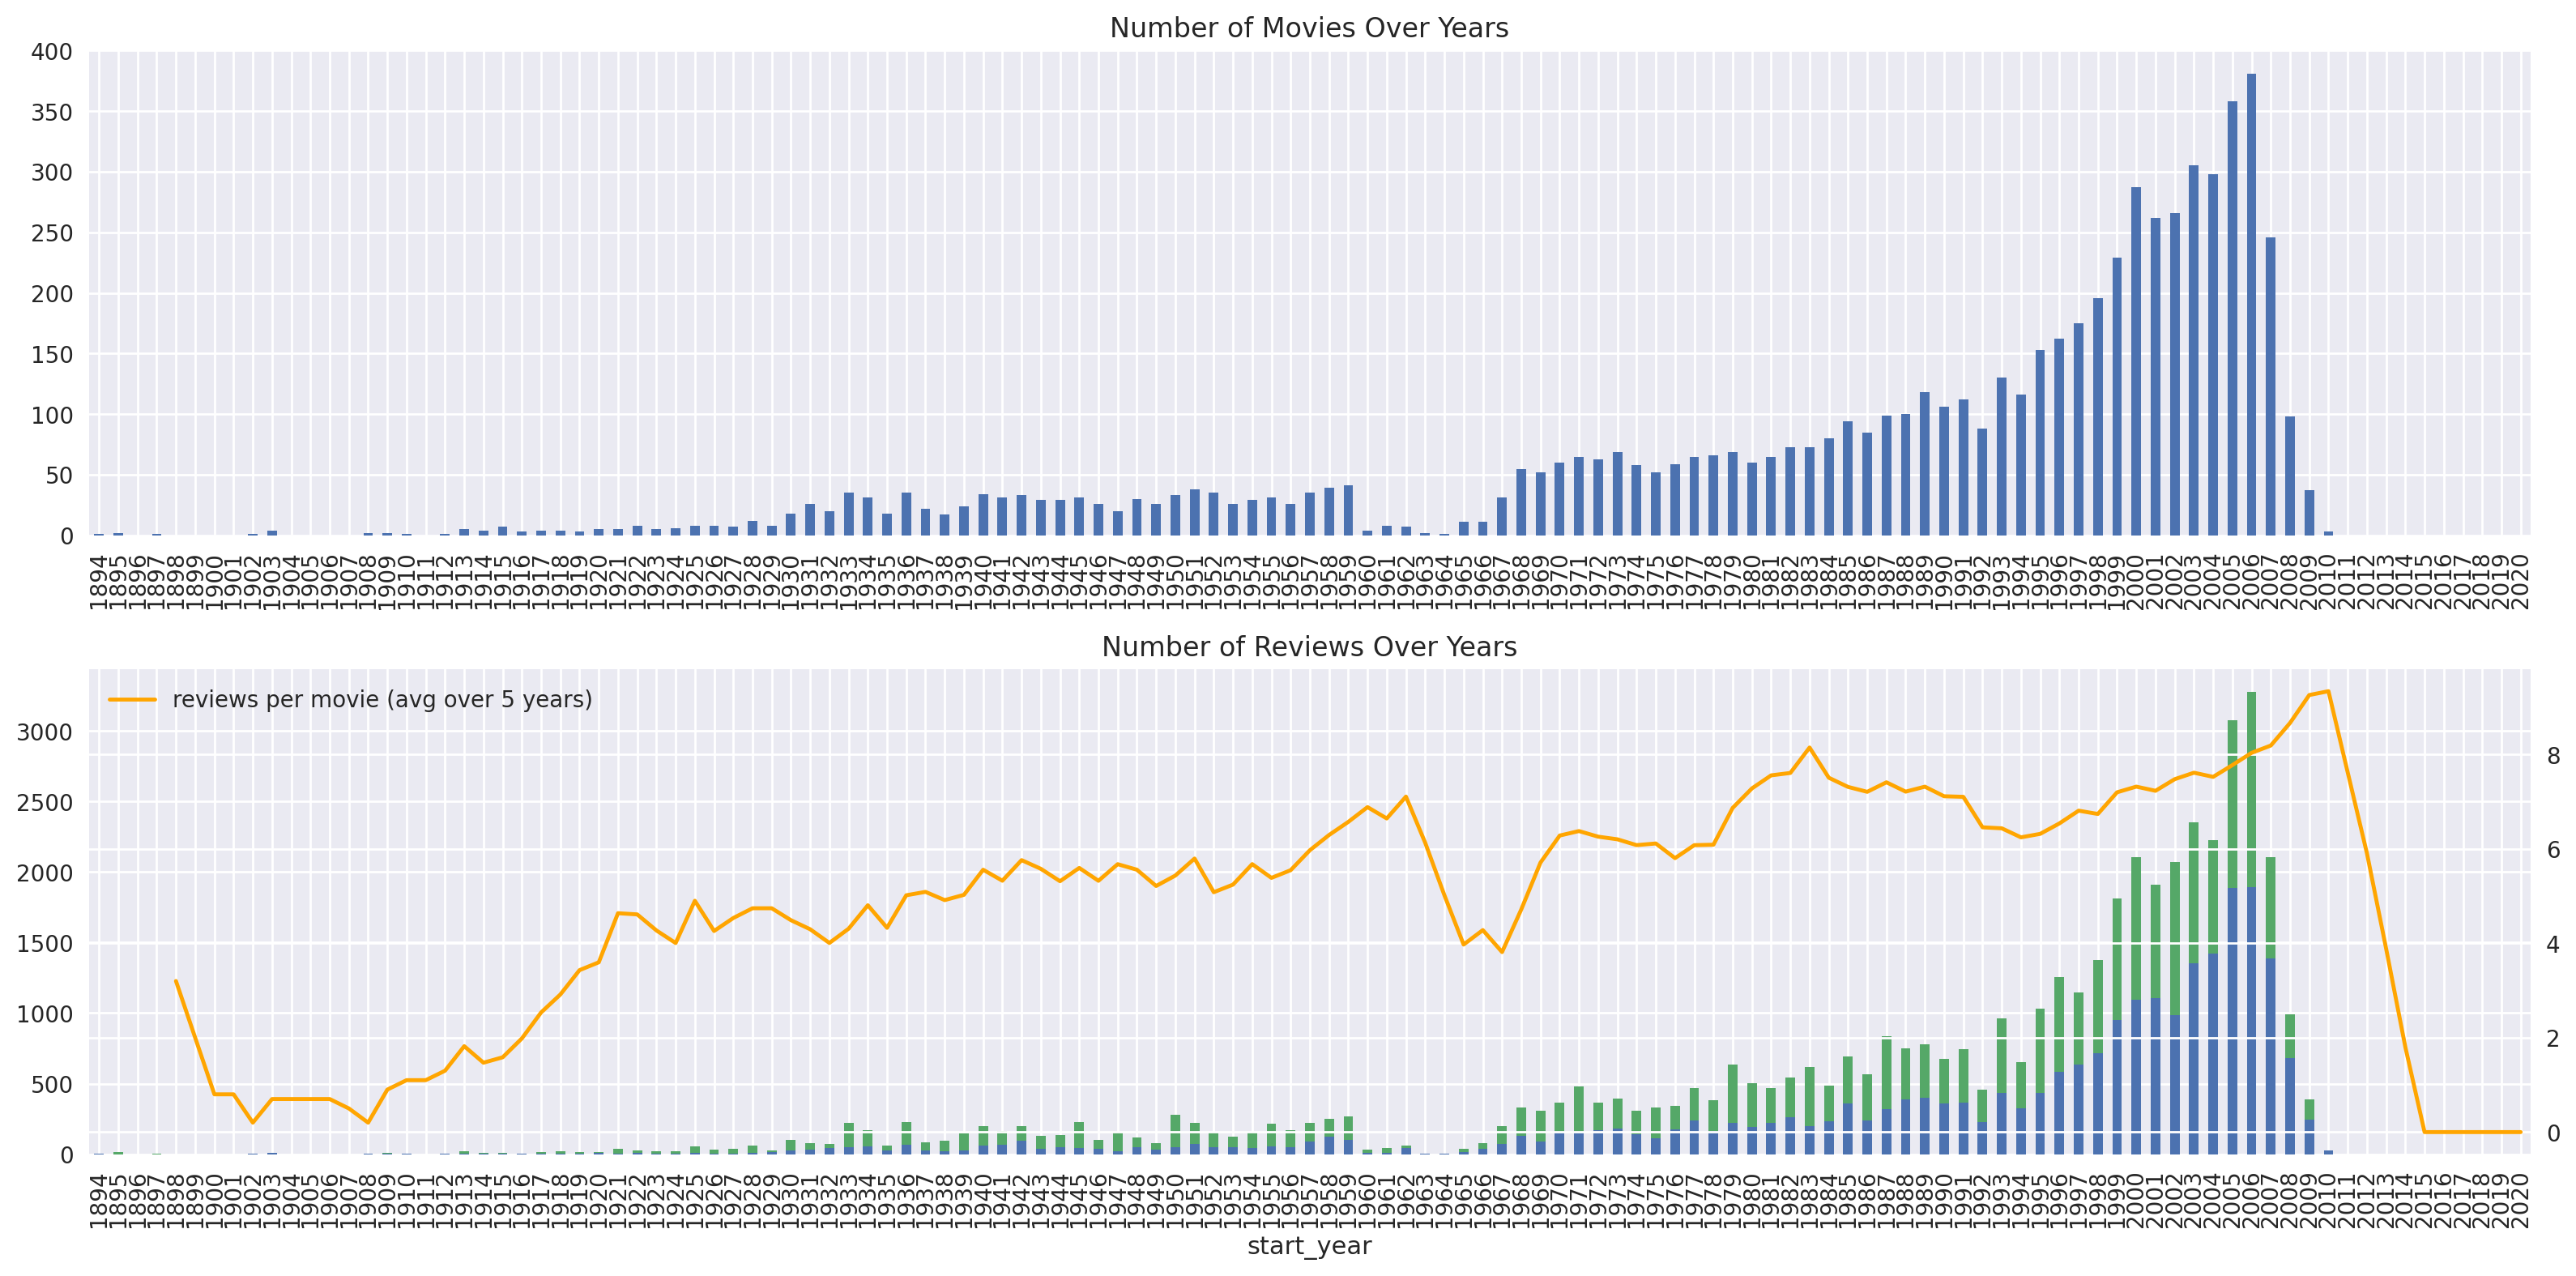

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()


The films produced the slowly increased the first fifty years then a sudden collapse in the 1960s. this is likely due to the major changes in the film industry. We see a rise in production in the late 1960s through 2006 where it peaked. The production appears to crash from 2007 on but could just be a decrease in the data recorded.

The percentage of good reviews to bad reviews is about 50/50 most years. This indicates the products were mainly hit or miss through the years.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

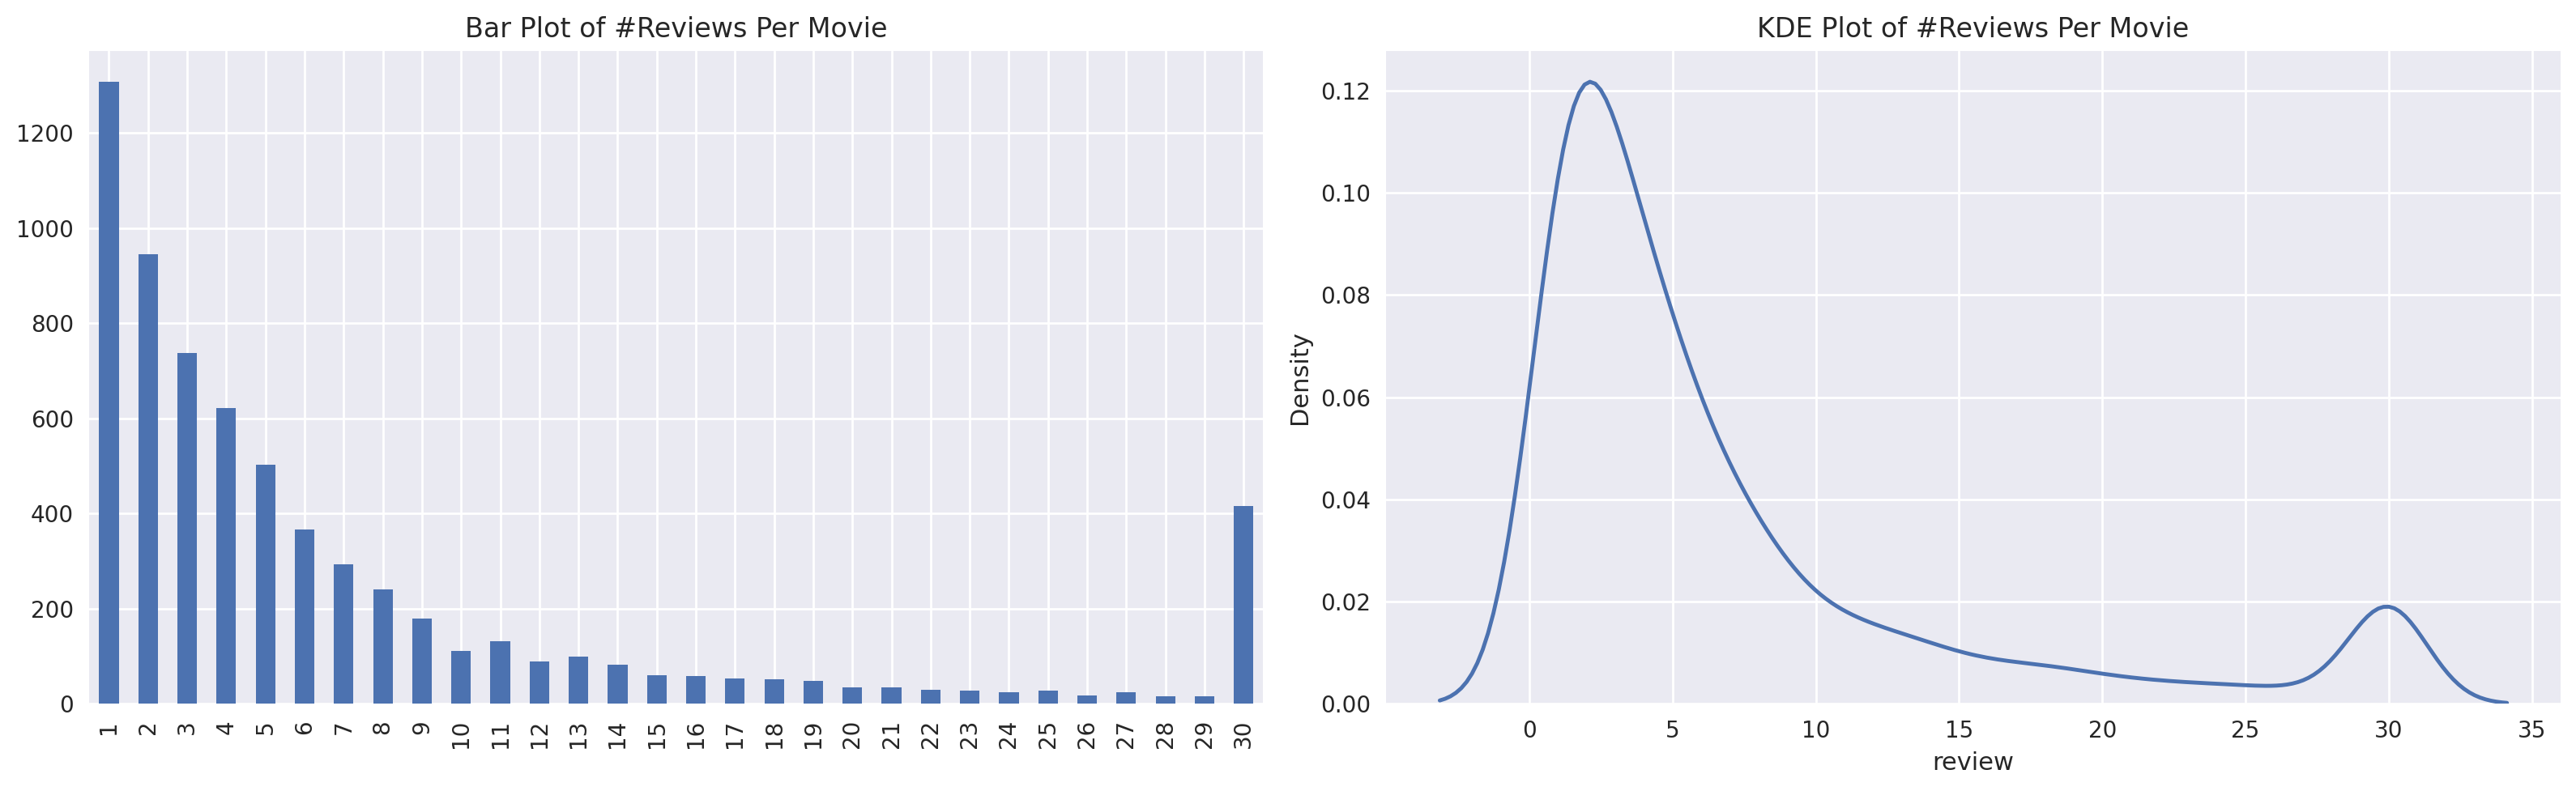

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

It is rarer to see movies with many reviews. The distribution of movies with one review is leads with about 1300. The number of movies decreases sharply as the number of reviews increase but surprisingly spikes up at 30 reviews.

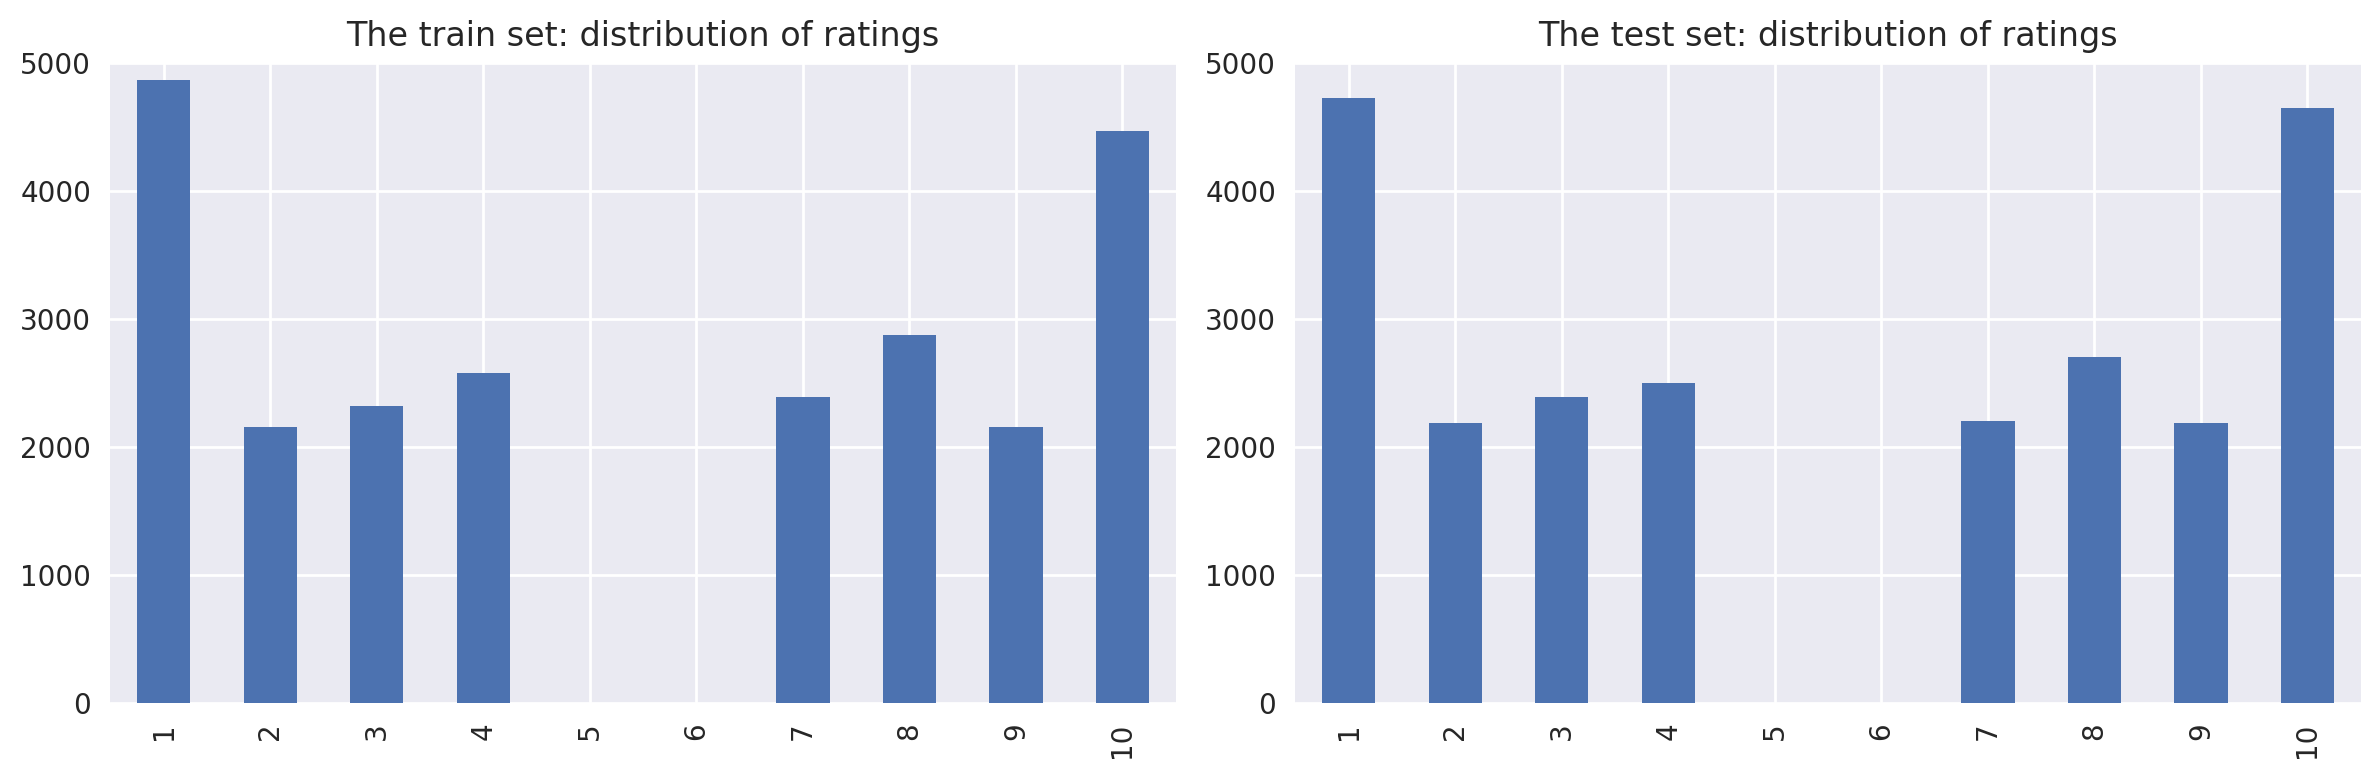

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution of ratings between the training and test sets are very similar so no need for any adjustments to avoid any possibility of bias.

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


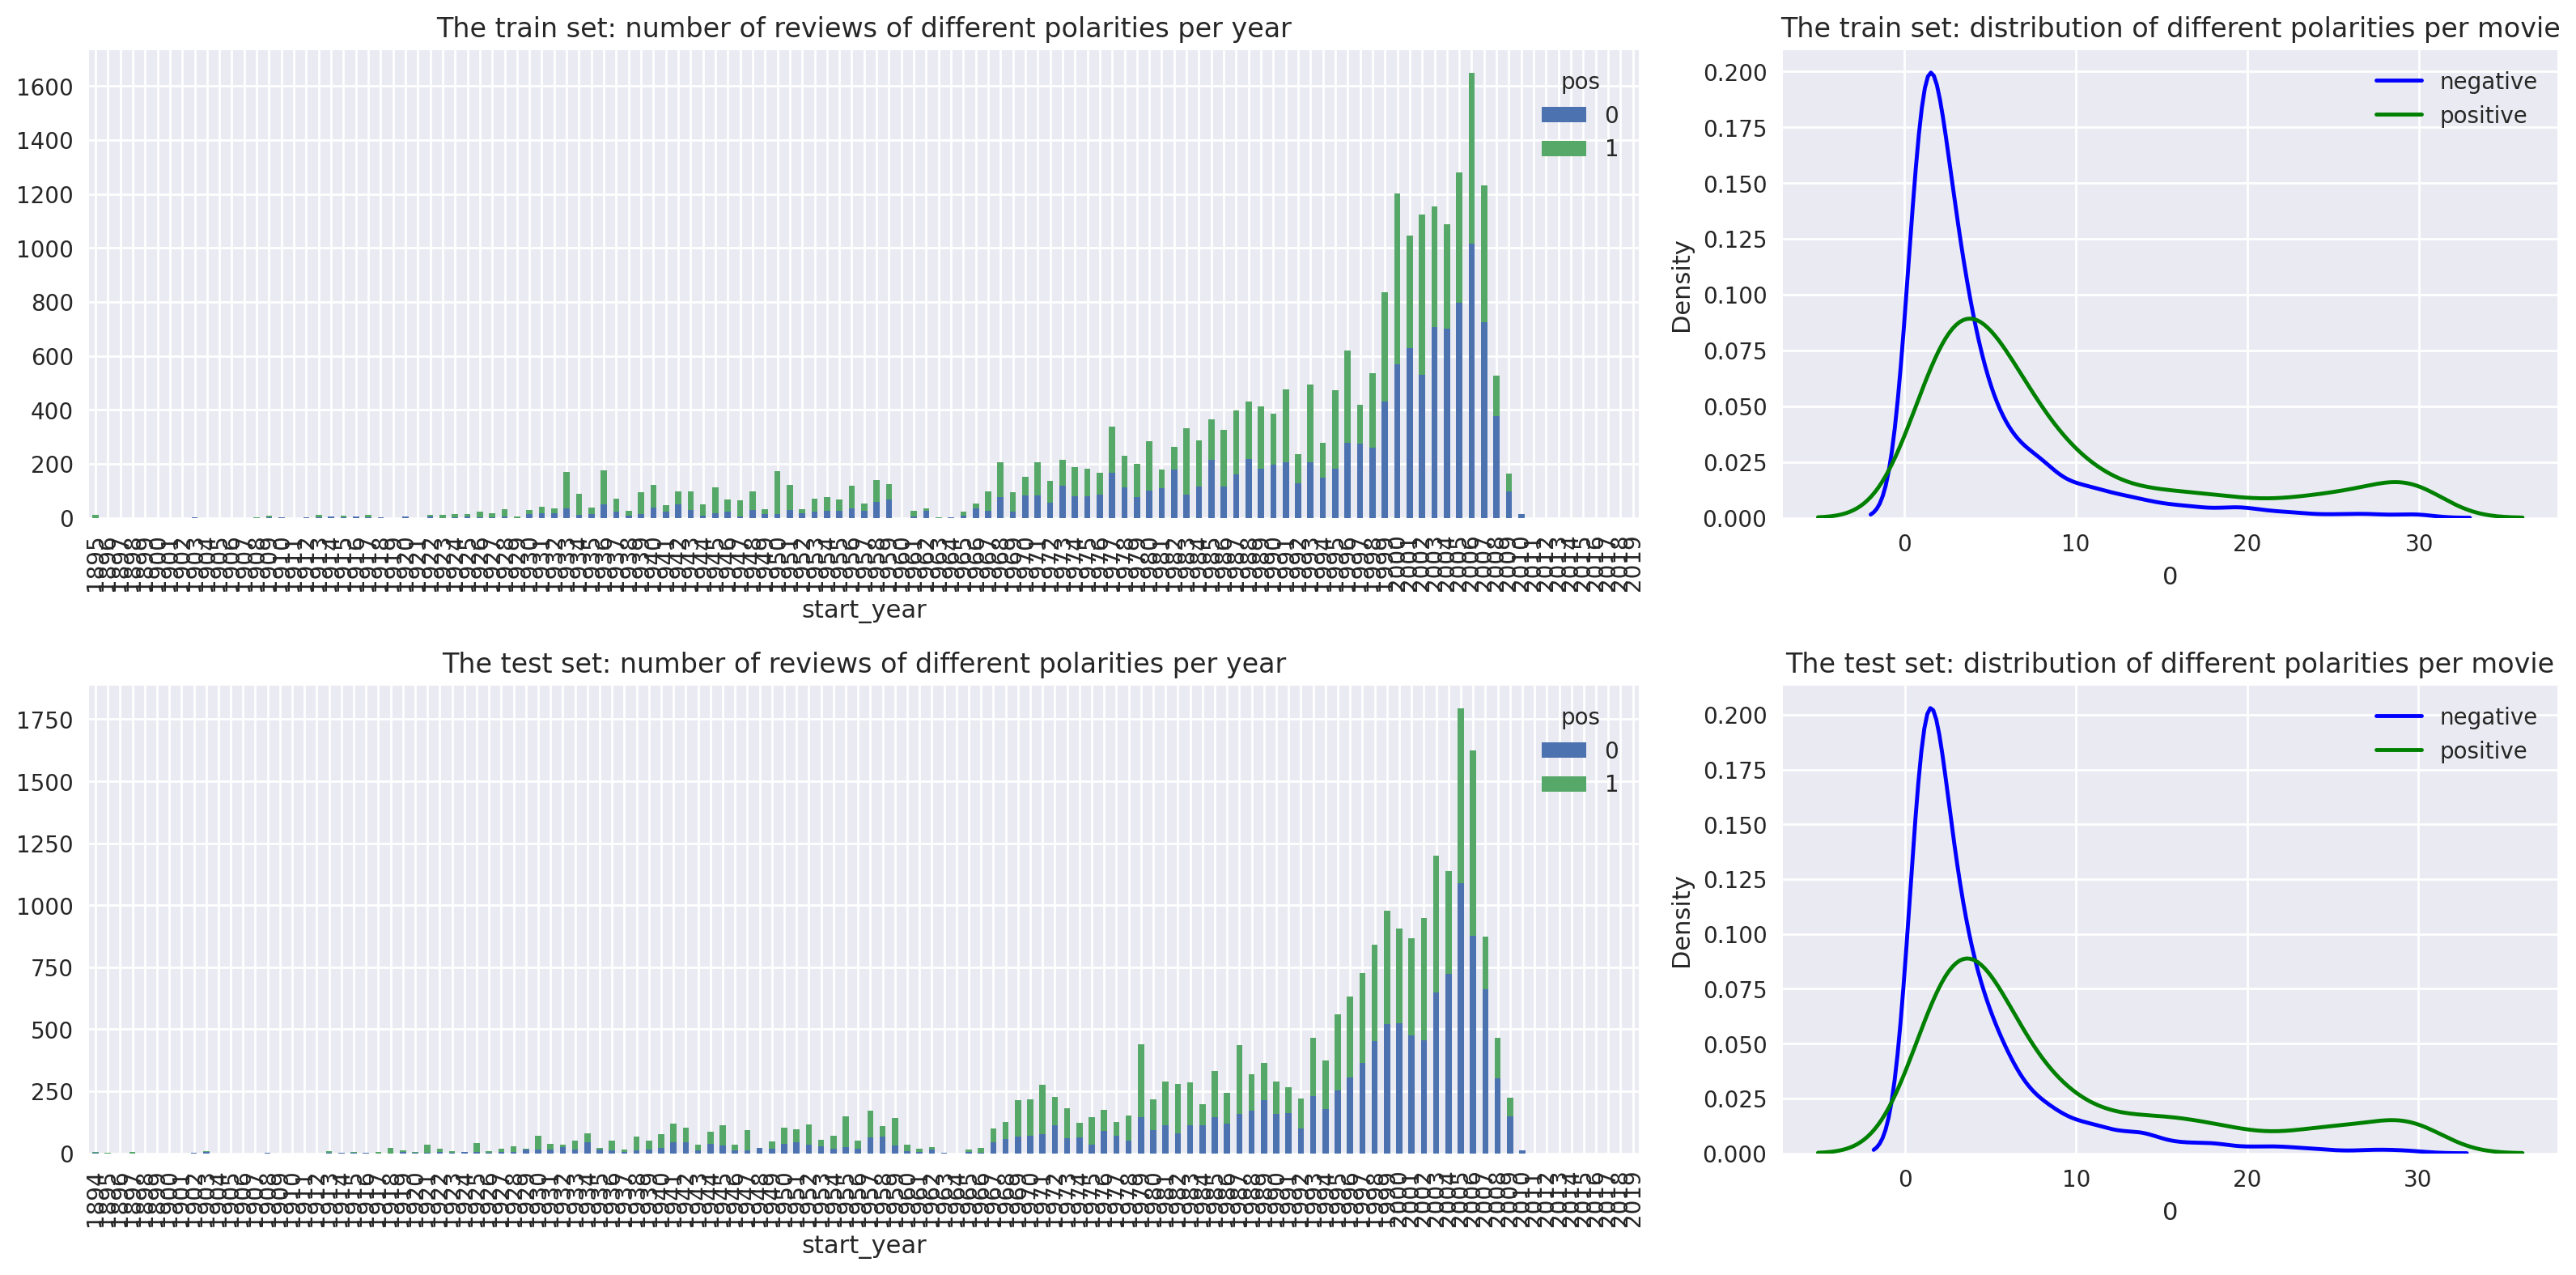

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Positive and negative values are distributed evenly between the training and test sets. We'll move on to creating and evaluating our models.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
pattern = r"[^a-z]"
df_reviews['review_norm'] = df_reviews['review'].apply(
    lambda text: ' '.join([word for word in re.sub(pattern, ' ', str(text).lower()).split() if word])
)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [15]:
X_train = df_reviews.query('ds_part == "train"').copy()
X_test = df_reviews.query('ds_part == "test"').copy()

y_train = X_train['pos']
y_test = X_test['pos']

print(X_train.shape)
print(X_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [16]:
from sklearn.dummy import DummyClassifier

In [17]:
model_0 = DummyClassifier(strategy='constant',constant=0)

In [18]:
model_0.fit(X_train,y_train)

DummyClassifier(constant=0, strategy='constant')

In [19]:
model_0.score(X_train,y_train)

0.5005883341738108

Our dummy classifier model produced a score of .50 which provides us with a baseline for our next models.

We'll move on to a logistic regression model to see how it compares with our baseline.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
stop_words = stopwords.words('english')

In [23]:
tfidf_vect = TfidfVectorizer(stop_words=stop_words)

In [24]:
X_train_1 = tfidf_vect.fit_transform(X_train['review_norm'])
X_test_1 = tfidf_vect.transform(X_test['review_norm'])

In [25]:
model_1 = LogisticRegression()

In [26]:
model_1.fit(X_train_1,y_train)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


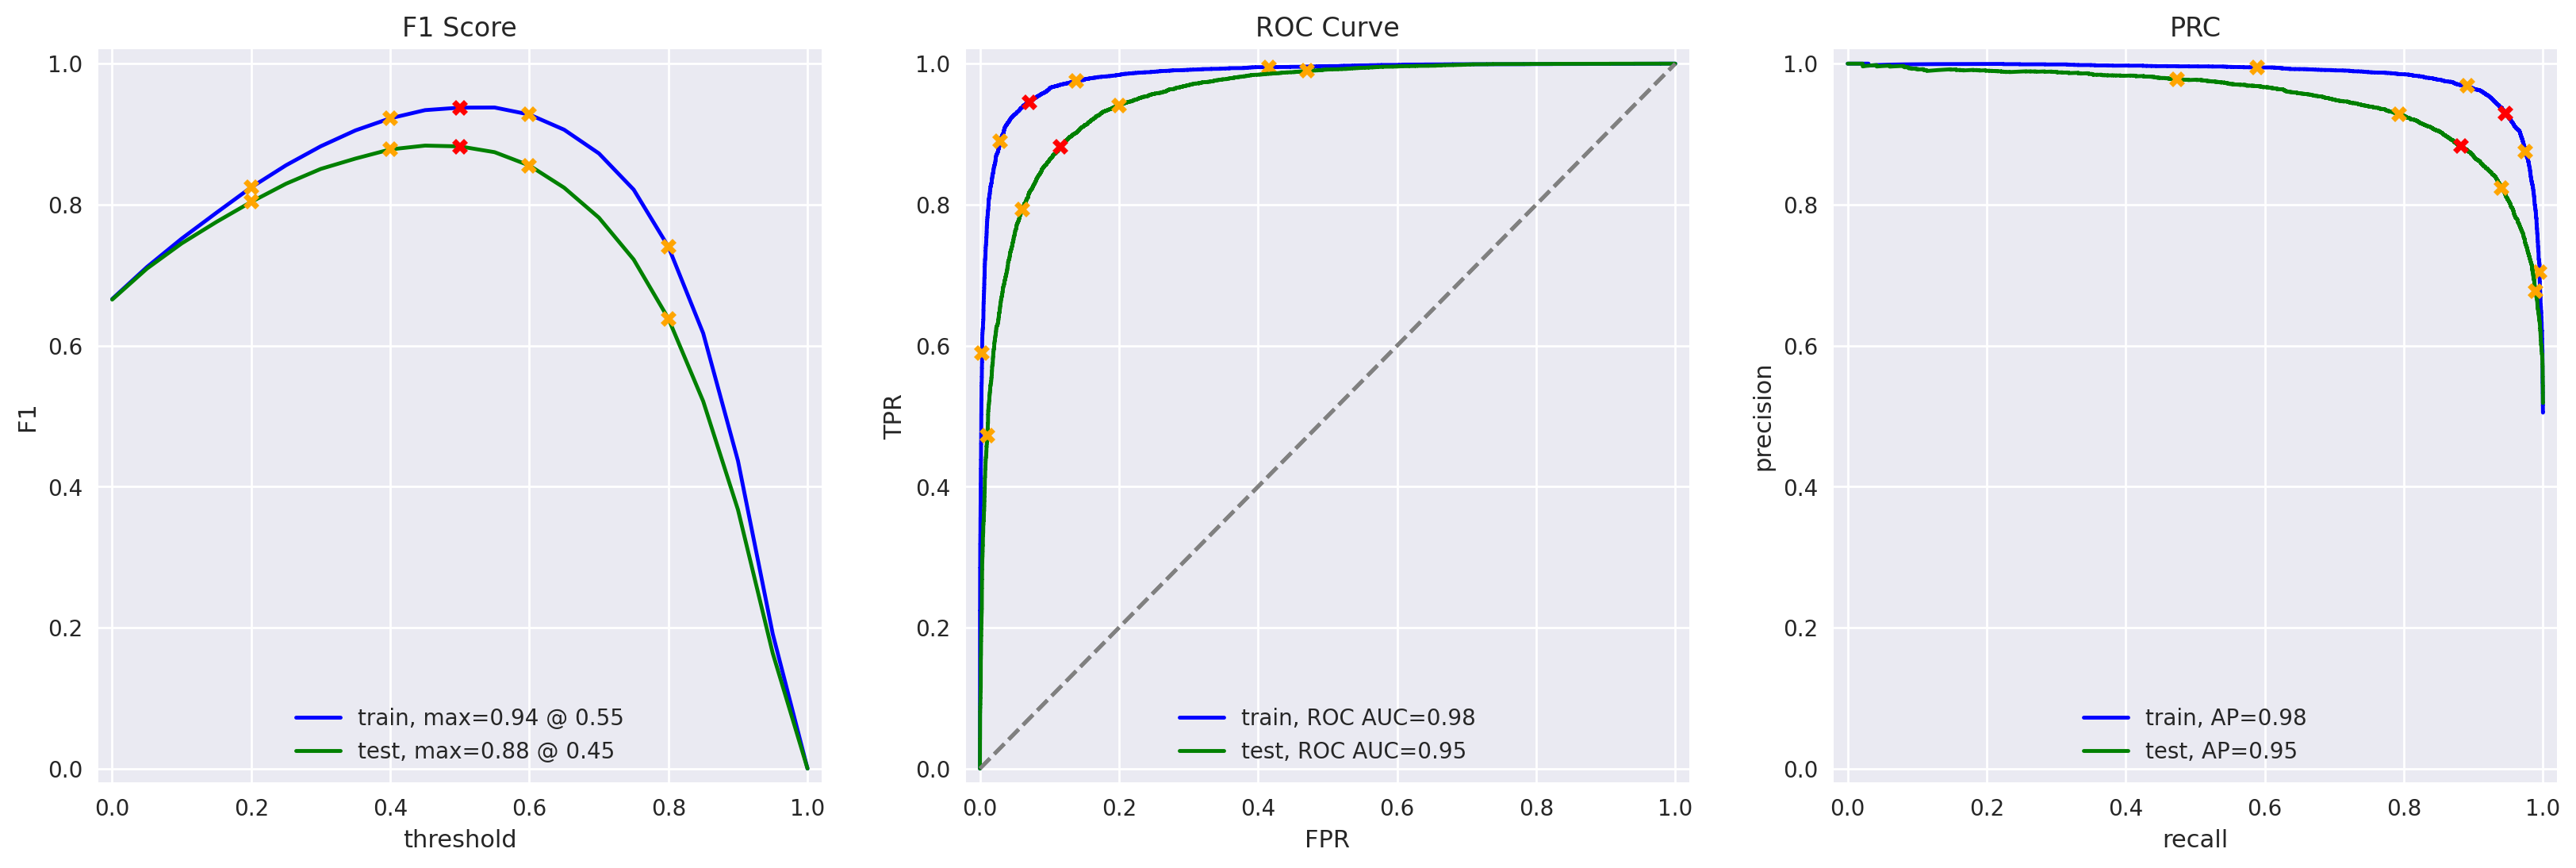

In [27]:
evaluate_model(model_1, X_train_1, y_train, X_test_1, y_test)

The logistic regression model produced impressive scores when trained with TF-IDF vectorized texts. The text vectorization method we used here did not cost much compututation, which is always a plus.

Chart shows the model trained well, and is neither overfit nor underfit. We'll move on to using a logistic regression model. We'll lemmatize the text and then extract the TF-IDF values to see how it compares.

### Model 3 - spaCy, TF-IDF and LR

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [30]:
X_train_2 = X_train['review_norm'].apply(text_preprocessing_3)
X_test_2 = X_test['review_norm'].apply(text_preprocessing_3)

In [31]:
tfidf_vect_2 = TfidfVectorizer(stop_words=stop_words)
tfidf_vect_2 = tfidf_vect_2.fit(X_train_2)

In [32]:
X_train_2 = tfidf_vect_2.transform(X_train_2)
X_test_2 = tfidf_vect_2.transform(X_test_2)

In [33]:
model_2 = LogisticRegression()
model_2.fit(X_train_2,y_train)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


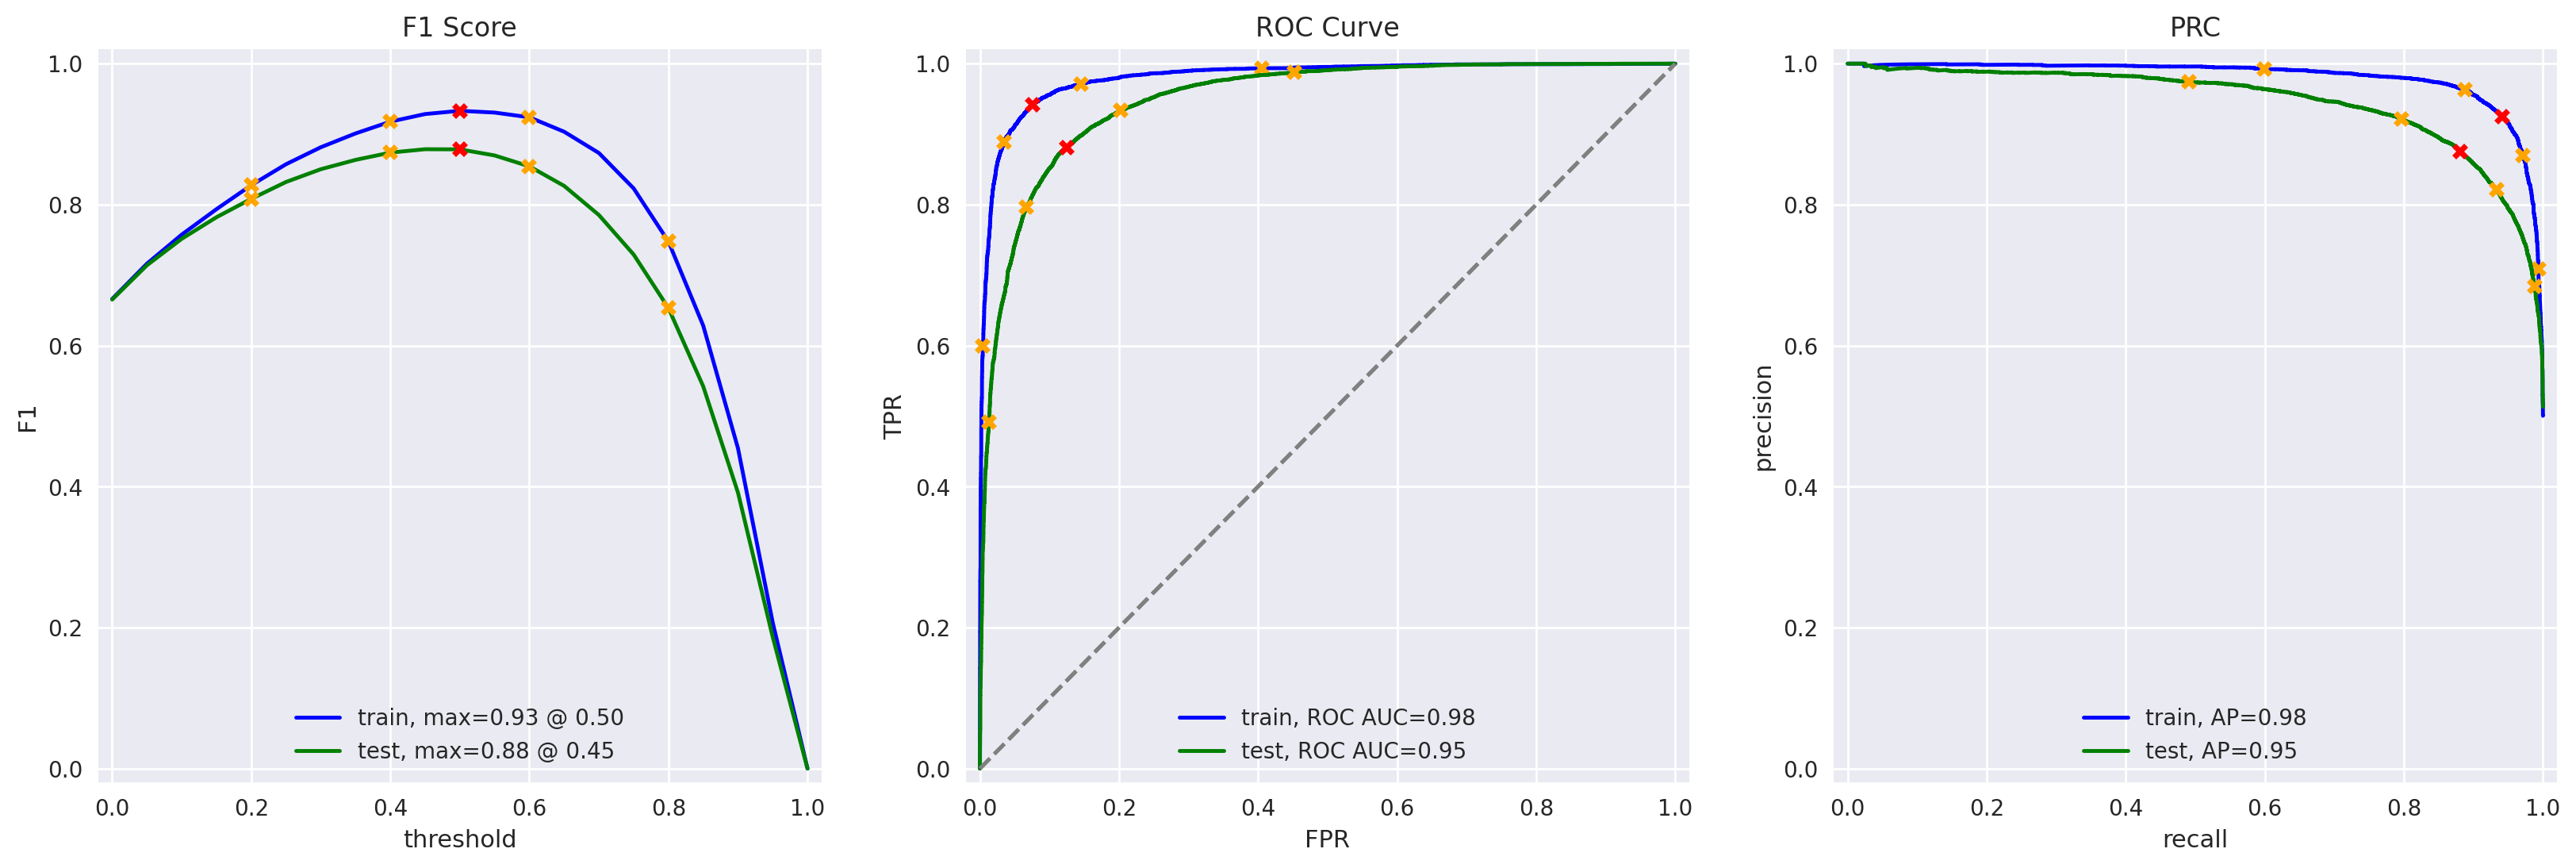

In [34]:
evaluate_model(model_2, X_train_2, y_train, X_test_2, y_test)

Our logistic model performed well but not much of a difference from our previous approach according to the scores but very costly computation with the text vectorization. Not a worthy tradeoff.

The charts show the model is not overfit nor underfit. We'll move on to the next approach, lemmatization with TF-IDF but we'll run the data through the LGBMClassifier model in the lightgbm library to see if there are any improvements.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [35]:
from lightgbm import LGBMClassifier

In [36]:
model_3 = LGBMClassifier()

In [37]:
model_3.fit(X_train_2,y_train)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


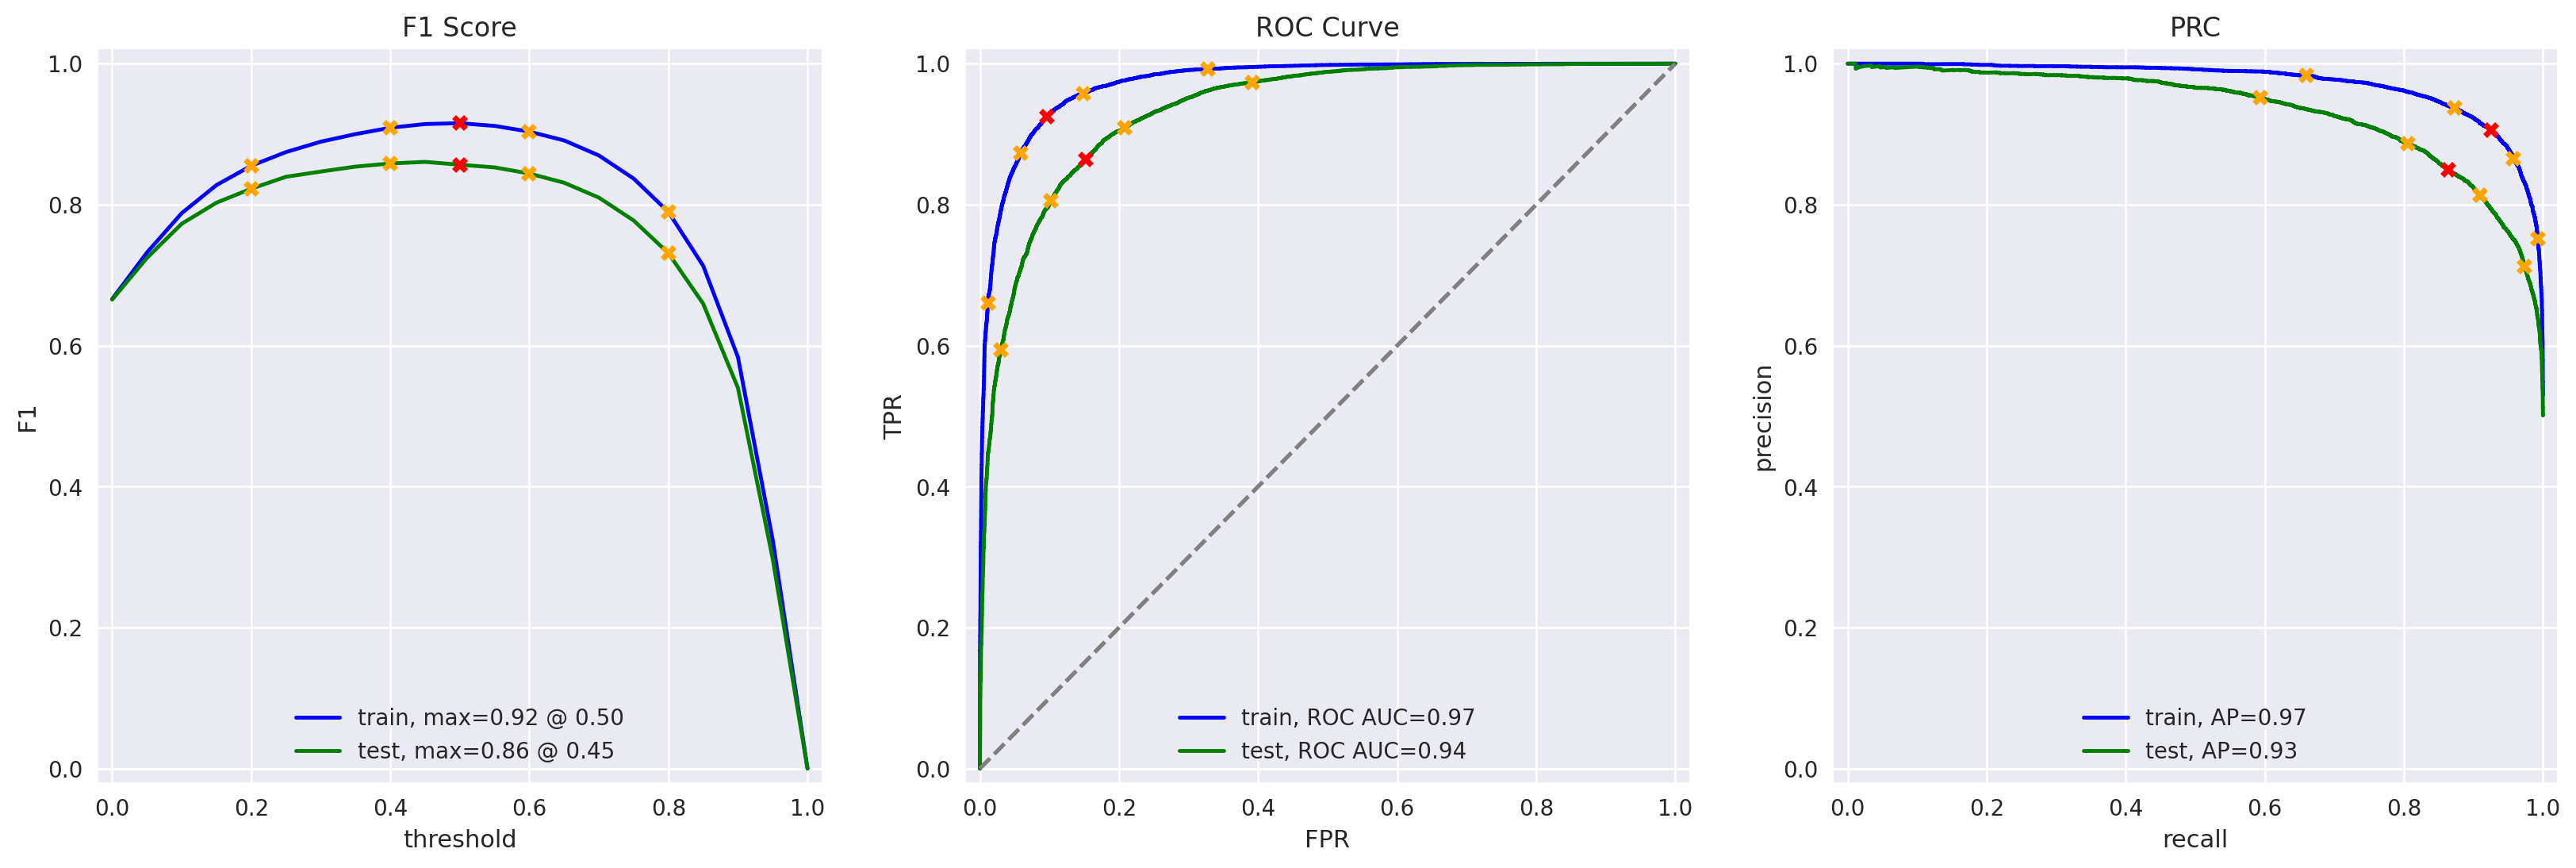

In [38]:
evaluate_model(model_3, X_train_2, y_train, X_test_2, y_test)

Our model here performed well but not an improvement from our last approach. Logistic models are showing to be a better model of choice with language learning thus far.

The charts indicate solid training as the model does not show signs of overfitting nor underfitting.

###  Model 9 - BERT

In [39]:
import torch
import transformers

In [40]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=35, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    for text in texts:
        ids = tokenizer.encode(
            text,
            add_special_tokens=True,
            max_length = 512,
            truncation = True
        )
        padded = np.array(ids + [0] * (512 - len(ids)))# <your code here>
    
        attention_mask = np.where(padded != 0,1,0)
    
        ids_list.append(padded)
    
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        batch_start = batch_size * i
        batch_end = batch_size * (i+1)
            
        ids_batch = torch.LongTensor(np.array(ids_list[batch_size*i:batch_size*(i+1)])).to(device)
        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.LongTensor(np.array(attention_mask_list[batch_start:batch_end])).to(device)
        
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [42]:
# Extracting small sample for BERT training/transformation
X_train_3 = X_train['review_norm'].sample(n=500,random_state=12345)
y_train_3 = y_train[X_train_3.index]
X_test_3 = X_test['review_norm'].sample(n=100,random_state=12345)
y_test_3 = y_test[X_test_3.index]

print(X_train_3.shape)
print(y_train_3.shape)
print(X_test_3.shape)
print(y_test_3.shape)

(500,)
(500,)
(100,)
(100,)


In [43]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(X_train_3, force_device='cpu')

Using the cpu device.


  0%|          | 0/15 [00:00<?, ?it/s]

In [44]:
test_features_9 = BERT_text_to_embeddings(X_test_3,force_device='cpu')

Using the cpu device.


  0%|          | 0/3 [00:00<?, ?it/s]

In [45]:
print(X_train_3.shape)
print(train_features_9.shape)
print(y_train_3.shape)

(500,)
(500, 768)
(500,)


In [46]:
print(train_features_9)

[[ 0.14787644 -0.11925144  0.30041516 ... -0.8102903   0.31966314
   0.36827764]
 [-0.41698676 -0.14320044  0.19795574 ... -0.84308636  0.7082724
  -0.10080358]
 [-0.54440784  0.21906115 -0.23261796 ... -0.65834576  0.5230161
   0.31399646]
 ...
 [-0.26804873  0.04758755  0.27107483 ... -0.8847233   0.88273615
   0.42532068]
 [-0.20254171 -0.18296702  0.42191285 ... -0.72386146  0.11002026
   0.34792003]
 [-0.12431204 -0.42151856  0.33563155 ... -0.2053463   0.05897036
   0.09583578]]


In [47]:
np.savez_compressed('features_9.npz', train_features_9=train_features_9,test_features_9 =test_features_9)

In [48]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [49]:
data = np.load('features_9.npz')

In [50]:
train_features_9 = data['train_features_9']

In [51]:
test_features_9 = data['test_features_9']

Here we've elected to use the MLPClassifier neural network within the sklearn library. 

The solver we'll be using is 'lbfgs' as the 'adam' solver is better used with larger sets of data (thousands). Layer size will be kept at 100 with only one hidden layer.

In [52]:
from sklearn.neural_network import MLPClassifier
model_9 = MLPClassifier(hidden_layer_sizes = (100),
                        solver = 'lbfgs',
                        random_state = 12345)
model_9.fit(train_features_9, y_train_3)

MLPClassifier(hidden_layer_sizes=100, random_state=12345, solver='lbfgs')

          train  test
Accuracy    1.0  0.86
F1          1.0  0.85
APS         1.0  0.81
ROC AUC     1.0  0.88


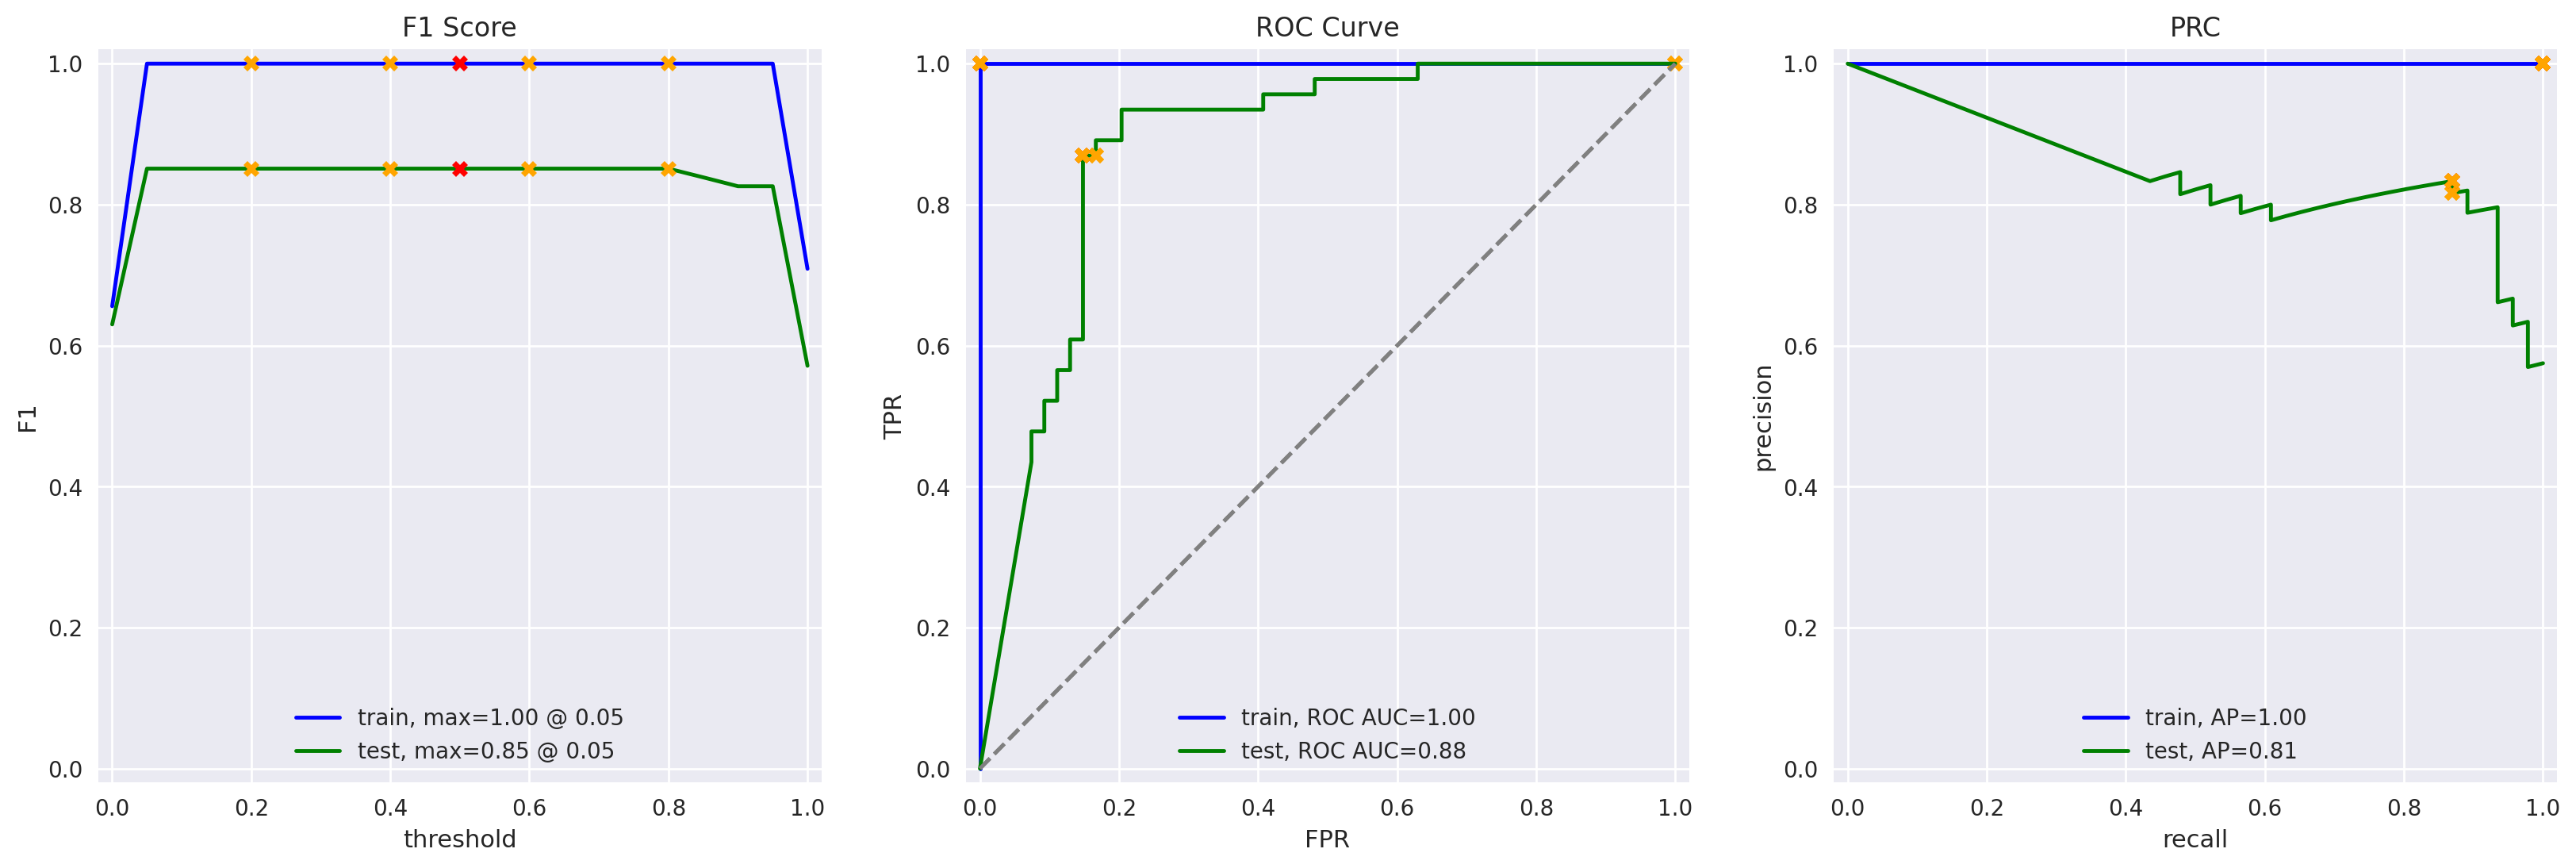

In [53]:
evaluate_model(model_9, train_features_9, y_train_3, test_features_9, y_test_3)

Impressive training with a perfect training score across the board. The test scores rank last among all other models. The BERT text transformations carry an extreme computational costs but we'll give it a shot with new reviews to see if the costs are worth its performance on new data.

Charts gives some signs of slight overfitting but scored well nonetheless. We'll move on to new reviews to see how each model performs.

## My Reviews

In [54]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(
    lambda text: ' '.join([word for word in re.sub(pattern, ' ', str(text).lower()).split() if word])
)# <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [55]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vect.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The results here show the model does well in predicting the sentiment of the new set of reviews. It missed on review numbers 5 & 6 which was predicted to be a negative review but were both positive. Not bad.

### Model 3

In [56]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vect_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didn t expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The resulting probabilities generated by model 2 wasn't very decisive. The model was off by 2 of 8 of the generated probabilities for the review sentiment.

### Model 4

In [57]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vect_2
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  i did not simply like it not my kind of movie
0.37:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.34:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.62:  i didn t expect the reboot to be so good writers really cared about the source material
0.67:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.30:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The results here are not very constistent. The probabilities of the first and third review have similar scores but have polar opposite sentiment. The probabilities generated doesn't show much confidence in its probabilities.

### Model 9

In [58]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
1.00:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.00:  i didn t expect the reboot to be so good writers really cared about the source material
1.00:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1.00:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Great predictions! All probabilities closes to 1 translates to a positive sentiment and a negative sentiment for the inverse. The model shows confidence in each prediction which shows signs of high intelligence being that it was only faulty on one prediction with the model only being trained with 500 observations. 

## Conclusions

In conclusion, this project demonstrates how models perform using different approaches in language processing.

Each model's approach varies in its overall build time. The text preprocessing and feature extraction processes extract the highest computational costs. As our project here demonstrates is the higher the computational costs the better the model's end results.

Each model performed very well in its training F1 scores and test F1 scores. When predicting the probabilities of each new review, the F1 scores did not translate well. This indicates that F1 is not always the best metric for language learning scenarios.

Our neural network (model_9) had the lowest F1 test score but had perfect accuracy with its predictions of probability predictions of the new reviews, whereas the other models did not show much decisiveness in its probabilities. Could it be the BERT text transformations or the neural network? Or is it both?

In summary, there are many different approaches to build language models. Each approach has a varying amount of computational costs. Depeding on the problem and the significance of any improvements in model performance, one approach may be better than another even if it's accuracy is lower. In this case, the BERT model proved to be the best choice, with the right amount of GPU available. Given we used a fraction of the training set to train our neural network, it was very accurate, and decisive in its probability predictions with the best performance out of all other 3 models.